# Network Based Intrusion Detection System in IOT Devices

Team:
    - Bhavnil Patel
    - Dhairya Sheth    
    - Vinay Pandit
Course: SCS_3253_024 Machine Learning by School of Continuing Studies, University of Toronto

Git Link : https://github.com/VinGPan/Machine_Learning_3252_project

Link to presentation : https://github.com/VinGPan/Machine_Learning_3252_project/blob/master/Project_Presentation.pptx

## 1.0 Introduction

In the field of cyber security there is significant interest in the problem of detection of malicious activities on the network. Intrusion detection is primarily reactive and responds to speciﬁc patterns or observed anomalies. However, a system that can proactively infer the upcoming malicious activities is needed so that we could react to such events before they cause any harm [1].

In this project we will be analysing three types of attacks:

- Distributed denial of service (DDOS) attack
    - The attacker attempts to make a machine or network resource unavailable to its intended users by temporarily or indefinitely disrupting services of a host connected to the Internet. [2]
- Port Scan Attack
    - The attacker attempts to identify exploitable vulnerabilities on targeted systems [3]
- Man In the Middle Attack
    - The attacker attempts to secretly relay and possibly alter the communications between two parties who believe that they are directly communicating with each other.[4]

We will develop a Machine Learning model which not only can **detect** attacks accurately but also can **predict** the future attacks. We show that a Random Forest based method can detect *Man In the Middle Attack* about 2 seconds in advance with promising F1 score of 0.89.

Main Contributions of this project:
- We are the first to build an end to end ML model on the Kaggle dataset https://www.kaggle.com/speedwall10/iot-device-network-logs. At the time of writing this report, there are NO publicly available kernels to detect/predict network attacks using this data except an exploratory data analysis provided at https://www.kaggle.com/mpwolke/iot-device-network-logs
- We have developed a model search framework for this project. Given a dataset (X, y) our framework
validates upto 120 different model pipelines and systematically stores the results.
- We have explored the possibility of utilizing a time-series analysis APIs provided by **PyEEG** 
(https://www.hindawi.com/journals/cin/2011/406391/), an open-source library to analyse EEG signals.




[1] Survey of Attack Projection, Prediction, and Forecasting in Cyber Security. https://www.researchgate.net/publication/327449459_Survey_of_Attack_Projection_Prediction_and_Forecasting_in_Cyber_Security)

[2] https://en.wikipedia.org/wiki/Denial-of-service_attack

[3] https://searchsecurity.techtarget.com/answer/What-is-a-port-scan-attack

[4] https://en.wikipedia.org/wiki/Man-in-the-middle_attack

## 2.0 Data Description

The dataset for this project is taken from Kaggle (https://www.kaggle.com/speedwall10/iot-device-network-logs). To generate this data, Ultrasonic Sensor with Arduino and NodeMCU was used to monitor the network and collect the network logs for IOT devices. Collected logs were further processed (ETLs) to extract various network transaction details for each network packet. In this project we will be using the preprocessed dataset for all our analysis.

For each datapoint, a **normality** value has been given and this is our target variable. The **normality** can take following values:
- 0 => Normal
- 1 => Wrong Setup
- 2 => DDOS (Distributed denial of service) attack
- 3 => Data type probing
- 4 => Scan Attack
- 5 => Man In the Middle Attack

### 2.1 Exploratory Data Analysis - Attack Detection

Let us begin by loading the data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data\Preprocessed_data.csv')
print("Data Set Dimensionality" + str(df.shape))
df.head(5)

Data Set Dimensionality(477426, 14)


,frame.number,frame.time,frame.len,eth.src,eth.dst,ip.src,ip.dst,ip.proto,ip.len,tcp.len,tcp.srcport,tcp.dstport,Value,normality
0,1,123722736684743,54,87971959760497,167275820076079,192168035,1921680121,6.0,40.0,0.0,49279.0,80.0,-99.0,0
1,2,123722736773147,62,87971959760497,167275820076079,192168035,1921680121,6.0,48.0,0.0,56521.0,80.0,-99.0,0
2,3,123722736824792,62,167275820076079,87971959760497,1921680121,192168035,6.0,48.0,0.0,80.0,56521.0,-99.0,0
3,4,123722736836228,54,167275820076079,87971959760497,1921680121,192168035,6.0,40.0,0.0,80.0,49279.0,-99.0,0
4,5,123722749684991,54,87971959760497,167275820076079,192168035,1921680121,6.0,40.0,0.0,56521.0,80.0,-99.0,0


The dataset has over 400K rows with following columns:
- frame.number : Index of the frame
- frame.time   : Time Stamp of the frame
- frame.len    : Frame length
- eth.src      : Descriptor of frame originator
- eth.dst      : Descriptor of frame destination
- ip.src       : IP address of frame originator
- ip.dst       : IP address of frame destination
- ip.proto     : Frame protocol type
- ip.len       : Frame IP length
- tcp.len      : Frame TCP length
- tcp.srcport  : TCP port of frame originator
- tcp.srcport  : TCP port of frame destination
- Value        : Transmission Value
- normality    : Transaction Type: Normal, Attack or Probe

In this project, we will build models to predict column **'normality'**. ie 'normality' is the target variable. For the purpose of prediction columns 'frame.len', 'ip.proto', 'ip.len', 'tcp.len', 'Value' can be used as predictors/features. Remaining columns are just descriptions of the frame and hence are ignored in this project.

Additionally, we will need column frame.time to arrange the data in time order.

In [2]:
df = df[['frame.time', 'frame.len', 'ip.proto', 'ip.len', 'tcp.len', 'Value', 'normality']]

In [3]:
df.isna().sum()

frame.time    0
frame.len     0
ip.proto      0
ip.len        0
tcp.len       0
Value         0
normality     0
dtype: int64

There are no NaNs in the dataset

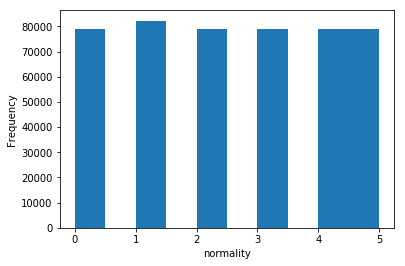

In [4]:
df["normality"].plot.hist()
plt.xlabel("normality")
plt.show()

Our target variable 'normality' can take values from 0 till 5. Luckily, we have highly balanced dataset. 

In [5]:
df.describe()

,frame.time,frame.len,ip.proto,ip.len,tcp.len,Value,normality
count,4.774260e+05,477426.000000,477426.000000,477426.000000,477426.000000,4.774260e+05,477426.000000
mean,1.256618e+14,120.658661,2.858263,97.242800,60.844678,5.649960e-01,2.489808
std,2.064214e+12,88.273425,3.284435,97.168551,87.682770,3.188912e+03,1.706533
min,1.237227e+14,42.000000,-1.000000,0.000000,0.000000,-9.900000e+01,0.000000
25%,1.243387e+14,42.000000,-1.000000,0.000000,0.000000,-5.000000e+00,1.000000
50%,1.249082e+14,98.000000,6.000000,84.000000,0.000000,-3.000000e+00,2.000000
75%,1.256493e+14,176.000000,6.000000,162.000000,110.000000,-2.000000e+00,4.000000
max,1.305135e+14,3484.000000,17.000000,3470.000000,3418.000000,2.202219e+06,5.000000


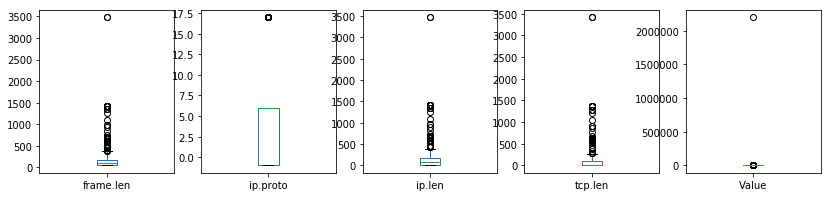

In [6]:
fig1, axs1 = plt.subplots(1, 5, figsize=(14, 3))
df["frame.len"].plot.box(ax=axs1[0])
df["ip.proto"].plot.box(ax=axs1[1])
df["ip.len"].plot.box(ax=axs1[2])
df["tcp.len"].plot.box(ax=axs1[3])
df["Value"].plot.box(ax=axs1[4])

From the box plot above we see that there are some outliers. In the below simple scheme, we identify and drop them.

In [7]:
df.drop(df['frame.len'].idxmax(), inplace=True)
df.drop(df['ip.len'].idxmax(), inplace=True)
df.drop(df['tcp.len'].idxmax(), inplace=True)
df.drop(df['Value'].idxmax(), inplace=True)
df = df[df['ip.proto'] < 10]

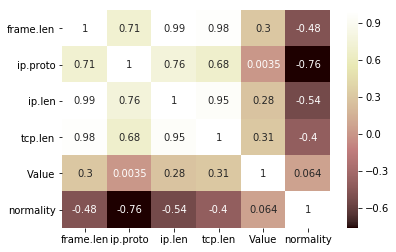

In [8]:
import seaborn as sns
dfcorr=df[['frame.len', 'ip.proto', 'ip.len', 'tcp.len', 'Value', 'normality']].corr()
sns.heatmap(dfcorr,annot=True,cmap='pink')
plt.show()

From the correlation plot above we can notice that columns 'frame.len', 'ip.proto', 'ip.len', 'tcp.len' have reasonable correlation with the target variable. There appears to be very high collinearity between columns 'ip.len' and 'tcp.len'.  


### 2.2 Time Series Data Analysis - Future Attack Prediction

We hypothesize that we can get useful patterns in 'frame.len', 'ip.proto' and other predictor values over time PRIOR to an attack. Hence, in this section, we will analyse this dataset as time series data using the time stamp column 'frame.time'.

Important end goal of this analysis is to re-arrange this dataset such that we can **predict future values of 'normality' (attacks)**. Here we introduce two new terms 'history' and 'lead'. The term **history** refers to number of time frames of the *past* data that we will be using for the prediction. The term **lead** refers to number of time frames *immediately before* the attack (or normal).

Here is an example to clarify the meaning of these new terms. Assume that we wish to predict the future 'normality' 100 timeframes in advance. Then we say lead = 100. Further assume that, we wish to analyse 600 timeframes of data to make this prediction. Then we say history = 600. Following layout shows *one row* of data in this new setup:

![title](imgs/img1.jpg)

                                
                                     
Code to ravel the data in time is stored in out github here:
https://github.com/VinGPan/Machine_Learning_3252_project/blob/master/src/s02_prepare_data.py

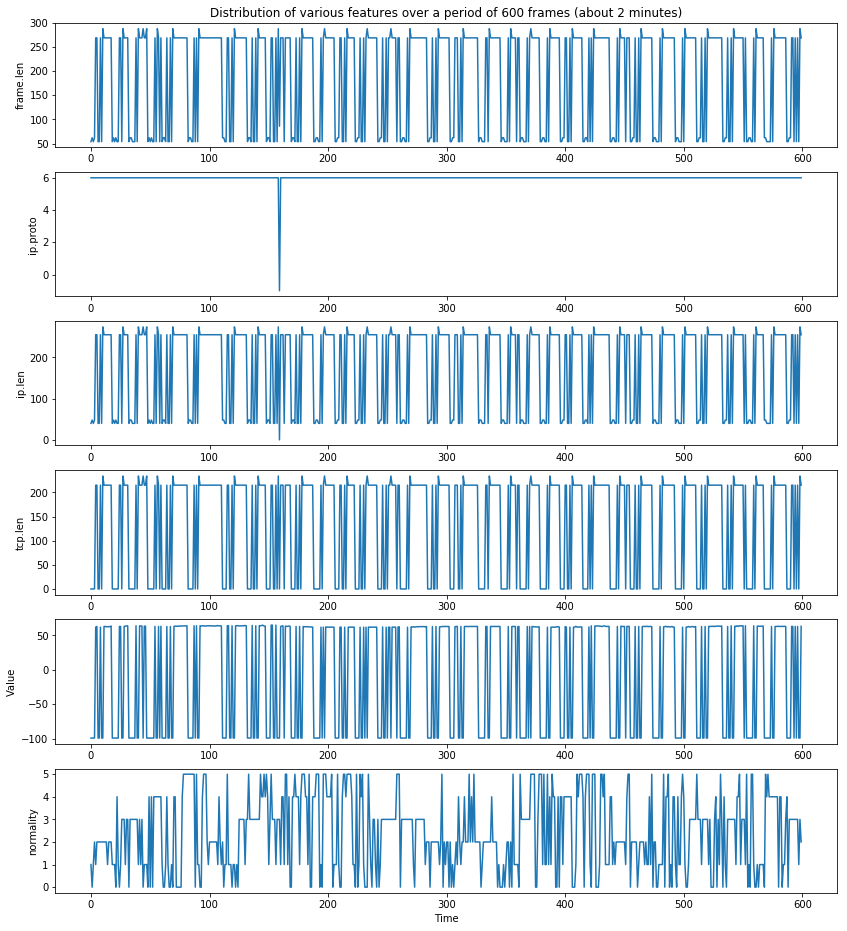

In [61]:
from src.s02_prepare_data import make_data 

# Sort the data in time order
df = df.sort_values(by=['frame.time'])
df = df.drop_duplicates('frame.time')

# Make dataset which combines every consecutive 600 time-slices as one ROW in the new dataset  
config = {}
config["data"] = {"cols" : ['frame.len', 'ip.proto', 'ip.len', 'tcp.len', 'Value'], "target" : 'normality', 'history' : 600, 'lead' : 1}
X, y = make_data(df, config)

# Plot one ROW of new dataset
fig1, axs1 = plt.subplots(6, 1, figsize=(14, 16))
axs1[0].plot(X[1][range(0, len(X[0]), 5)])
axs1[0].set_ylabel('frame.len')
axs1[0].set_title('Distribution of various features over a period of 600 frames (about 2 minutes)')
axs1[1].plot(X[1][range(1, len(X[0]), 5)])
axs1[1].set_ylabel('ip.proto')
axs1[2].plot(X[1][range(2, len(X[0]), 5)])
axs1[2].set_ylabel('ip.len')
axs1[3].plot(X[1][range(3, len(X[0]), 5)])
axs1[3].set_ylabel('tcp.len')
axs1[4].plot(X[1][range(4, len(X[0]), 5)])
axs1[4].set_ylabel('Value')
axs1[5].plot(y[0:600])
axs1[5].set_ylabel('normality')
axs1[5].set_xlabel('Time');

Above plot shows a row of this time series dataset. We note that, most of variables have systematic patterns over the time with exception of column 'ip.proto'. The last row in the column is our target variable 'normality'.

## 3.0 Model Search Framework

We have developed a model search framework for this project. Model search framework is a collection of model pipelines which is generated in combinatorial fashion. Given a dataset (X, y) our framework
validates upto 120 different model pipelines and systematically stores the results. 

Our objective here is to make use of as many ideas and concepts relevant to classification model development as possible for this project. Hence our framework generates several pipelines as combinations of the following:

- Preprocessing
    - Min-Max transform
    - Standard normal transform
    - No Preprocessing
- Dimensionality Reduction
    - PCA
    - Kernel PCA
    - Locally Linear Embedding
    - ISO Map
    - No Dimensionality Reduction
- Classifiers
    - Logistic Regression
    - Naive Bayes
    - kNN
    - Random Forest
    - SVC
    - XGBoost 
    - AdaBoost
    - Gradient Boosting
    
Further, to decide on hyperparameters the framework carries out Grid Search with cross validation. Following hyperparameters are tuned:
- Dimensionality Reduction
    - PCA 
        - n_components
    - Kernel PCA 
        - n_components
    - Locally Linear Embedding
        - n_components
        - n_neighbors 
    - ISO Map
        - n_components
        - n_neighbors
- Classifiers
    - Logistic Regression
        - penalty
        - C
        - class_weight
    - kNN
        - n_neighbors
        - weights
        - metric
    - Random Forest
        - max_depth
        - min_samples_split
        - n_estimators
    - XGBoost
        - learning_rate
        - n_estimators
    - AdaBoost
        - n_estimators
    - Gradient Boosting
        - learning_rate, n_estimators

The logic of the framework can be found in our github at https://github.com/VinGPan/Machine_Learning_3252_project/blob/master/src/s04_build_models.py

## 4.0 Feature Engineering

It can be beneficial to consider longer historical values while predicting the future Normality values (attacks). However, increasing the history will also increase the dimensionality of the data. As explained in the previous section, our framework searches through various dimensionality reduction techniques such as PCA. Along with that, we will also be generating several statistical features over the time-series features.

Feature extraction from time-series data is done in many well known problems like stock prediction, ECG, EEG analysis etc. In this project we will be using one such open-source library called **PyEEG** (https://www.hindawi.com/journals/cin/2011/406391/). Though PyEEG was originally designed to analyse EEG signals, the APIs provided are generic statistical tools and utility of these can be extended to any time-series data. We will be using following feature extractors in this project:

- **Power Spectral Analysis**: Measure of signal's power content versus frequency
- **Entropy and Information**: Entropy quantifies how "informative" or "surprising" the entire random variable is
- **Fractal Dimension**: A fractal dimension is an index for characterizing fractal patterns. Fractals are self-similar structures but with different scales.
- **Hurst Exponent**: a measure of long-term memory of time series
- **Detrended Fluctuation Analysis**: a method for determining the statistical self-affinity of a signal.

## 5.0 Results

As a first step, we sort the data in time order using frame.time column and then we treat first 80% rows as training data and the remaining as test data.

In [10]:
from src.s01_train_test_split import do_train_test_split

do_train_test_split()

Data Set Dimensionality (477268, 14)
Sampling Frequency = 5
Train Set Dimensionality (381814, 14)
Test Set Dimensionality (95454, 14)


In all our experiments we will be using following 5 columns as predictors of target column **normality**:
- frame.len
- ip.proto
- ip.len
- tcp.len
- Value

### 5.1 Experiment 1 - Detect Attacks

In this experiment we will develop an Attack Detection Model. Objective of this model is to identify whether the current frame is an instance of attack or not. We will use the details of the frame 'frame.len', 'ip.proto', 'ip.len', 'tcp.len', 'Value' to predict the 'normality'.

In [11]:
from src.s02_prepare_data import prepare_data
from src.s04_build_models import build_models

exp_yml_name = 'experiments/exp_01.yml'
prepare_data(exp_yml_name, training=True)
exp1_scores, exp1_top_scores = build_models(exp_yml_name)
print("Top 3 classifiers")
exp1_top_scores

Train Set Dimensionality (381814, 5)
Top 3 classifiers


,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,knn,none,none,100.0,100.0,1.0
1,random_forest,none,none,100.0,100.0,1.0
2,knn,min_max,none,99.99738096485254,99.99752940013836,0.999973809370695


Detecting **normality** from the frame details like frame length, ip length yeilds 100 % accurate model. Above table provides result for top 3 performing models. In Appendix A we have provided accuracy scores for all the models our Model Search Framework tried for this Experiment.

Though, identifying the attack in real-time is extremely important, to act on an attack we need to predict possibility of such even well in advance. Hence, in the subsequent experiments we will try pose this problem as Attack Prediction problem.

### 5.2 Experiment 2 - Predict Near Future Attacks

To predict the future attack, it is important to analyse how the predictor variables vary over the period of time. Hence in this experiment we will feed the feature values of every 5 time frames into the learning model and predict the future **normality**. Hence the total feature size will be 5x5 = 25. In this experiment we predict the **normality** 10 frames in advance. ie about 2 seconds in advance.

In [12]:
exp_yml_name = 'experiments/exp_02.yml'
prepare_data(exp_yml_name, training=True)
exp2_scores, exp2_top_scores = build_models(exp_yml_name)
print("Top 3 classifiers")
exp2_top_scores

Train Set Dimensionality (76352, 25)
Top 3 classifiers


,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,random_forest,standard_scalar,none,56.54793085385018,48.6838392728484,0.5246877056022392
1,knn,none,none,53.8108957569408,48.286852593996656,0.5343482773353966
2,gradboost,min_max,none,56.469355683603986,47.624158528862964,0.5391106776392328


Clearly, predicting future load is significantly harder task. Our model search framework identified Random Forest based model to be the best choice. However, accuracy sharply dropped to 56%. 

Above table provides result for top 3 performing models. In Appendix B we have provided accuracy scores for all the models our Model Search Framework tried for this Experiment.

### 5.3 Experiment 3 - Predict Farther Future Attacks

In this experiment we will predict the **normality** even earlier in time, 100 time frames in advance. All the other setup is similar to that of Experiment 2. So, lead = 100 and history = 5, total features = 25

In [13]:
exp_yml_name = 'experiments/exp_03.yml'
prepare_data(exp_yml_name, training=True)
exp3_scores, exp3_top_scores = build_models(exp_yml_name)
print("Top 3 classifiers")
exp3_top_scores

Train Set Dimensionality (76262, 25)
Top 3 classifiers


,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,random_forest,min_max,none,48.0529697128622,43.25722809515686,0.4493202118288043
1,adaboost,min_max,pca,45.692933001180016,42.6272140709298,0.4275977618052473
2,gradboost,min_max,pca,46.112495083256846,42.342532911861305,0.44434970820119657


As expected prediction accuracy drops even further to 48%. In Appendix C we have provided accuracy scores for all the models our Model Search Framework tried for this Experiment.

### 5.4 Experiment 4 - Predict Near Future Attacks using long history 

In this experiment we will analyse longer historical data to predict future attacks. Unlike previous two experiments here will feed the feature values of consecutive 100 historical time frames into the learning model. So, lead = 10 and history = 100. However note that the number of features would increase to 100x5 = 500. Instead of feeding *raw* 100 historical features directly to the model, in this experiment we will be utilizing PyEEG APIs to compute a set of 16 statistical features. These features will be computed separately for each of the 5 columns yielding total of 80 features.

In [14]:
exp_yml_name = 'experiments/exp_04.yml'
prepare_data(exp_yml_name, training=True)
exp4_scores, exp4_top_scores = build_models(exp_yml_name)
print("Top 3 classifiers")
exp4_top_scores

Train Set Dimensionality (626, 80)
Top 3 classifiers


,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,random_forest,standard_scalar,isomap,17.46031746031746,28.88033019611967,0.19439393502187016
1,adaboost,standard_scalar,lle,17.46031746031746,28.663003663003668,0.1703493874546506
2,xgboost,none,lle,15.873015873015872,28.30502830502831,0.19296536796536792


Unfortunately, we could not improve the accuracy by using longer history. Accuracy further dropped to 17%. In Appendix D we have provided accuracy scores for all the models our Model Search Framework tried for this Experiment.

### 5.5 Experiment 5 - Predict Farther Future Attacks using long history

This experiment is similar to Experiment 4 but lead time will be changed to 100 time steps. So, lead = 100 and history = 100, total features = 80

In [15]:
exp_yml_name = 'experiments/exp_05.yml'
prepare_data(exp_yml_name, training=True)
exp5_scores, exp5_top_scores = build_models(exp_yml_name)
print("Top 3 classifiers")
exp5_top_scores

Train Set Dimensionality (536, 80)
Top 3 classifiers


,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,random_forest,none,isomap,22.22222222222222,33.699633699633694,0.22882877430807713
1,adaboost,min_max,none,14.814814814814813,26.520146520146522,0.15775630703166937
2,random_forest,standard_scalar,lle,14.814814814814813,26.167166167166165,0.13288207893471052


Similar to Experiment 4, accuracy is lower if we use longer history. In Appendix E we have provided accuracy scores for all the models our Model Search Framework tried for this Experiment.

### 5.6 Comparison

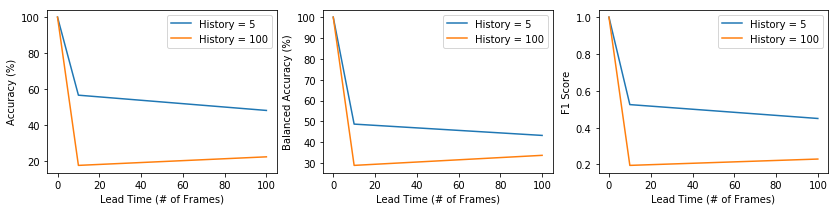

In [16]:
lead = [0, 10, 100]
lead_scores_acc = [exp1_top_scores.loc[0].accuracy, exp2_top_scores.loc[0].accuracy, exp3_top_scores.loc[0].accuracy]
lead_scores_feat_eng_acc = [exp1_top_scores.loc[0].accuracy, exp4_top_scores.loc[0].accuracy, exp5_top_scores.loc[0].accuracy]
lead_scores_bal_acc = [exp1_top_scores.loc[0].balanced_accuracy, exp2_top_scores.loc[0].balanced_accuracy, exp3_top_scores.loc[0].balanced_accuracy]
lead_scores_feat_eng_bal_acc = [exp1_top_scores.loc[0].balanced_accuracy, exp4_top_scores.loc[0].balanced_accuracy, exp5_top_scores.loc[0].balanced_accuracy]
lead_scores_f1 = [exp1_top_scores.loc[0].f1_score, exp2_top_scores.loc[0].f1_score, exp3_top_scores.loc[0].f1_score]
lead_scores_feat_eng_f1 = [exp1_top_scores.loc[0].f1_score, exp4_top_scores.loc[0].f1_score, exp5_top_scores.loc[0].f1_score]

lead_scores_acc = [float(v) for v in lead_scores_acc]
lead_scores_feat_eng_acc = [float(v) for v in lead_scores_feat_eng_acc]
lead_scores_bal_acc = [float(v) for v in lead_scores_bal_acc]
lead_scores_feat_eng_bal_acc = [float(v) for v in lead_scores_feat_eng_bal_acc]
lead_scores_f1 = [float(v) for v in lead_scores_f1]
lead_scores_feat_eng_f1 = [float(v) for v in lead_scores_feat_eng_f1]

fig1, axs1 = plt.subplots(1, 3, figsize=(14, 3))
axs1[0].plot(lead, lead_scores_acc, label='History = 5')
axs1[0].plot(lead, lead_scores_feat_eng_acc, label='History = 100')
axs1[0].set_label("Validation Accuracy")
axs1[0].set_ylabel("Accuracy (%)")
axs1[0].set_xlabel("Lead Time (# of Frames)")
axs1[0].legend()

axs1[1].plot(lead, lead_scores_bal_acc, label='History = 5')
axs1[1].plot(lead, lead_scores_feat_eng_bal_acc, label='History = 100')
axs1[1].set_label("Validation Balanced Accuracy")
axs1[1].set_xlabel("Lead Time (# of Frames)")
axs1[1].set_ylabel("Balanced Accuracy (%)")
axs1[1].legend()

axs1[2].plot(lead, lead_scores_f1, label='History = 5')
axs1[2].plot(lead, lead_scores_feat_eng_f1, label='History = 100')
axs1[2].set_label("Validation F1 Score")
axs1[2].set_ylabel("F1 Score")
axs1[2].set_xlabel("Lead Time (# of Frames)")
axs1[2].legend()
plt.show()

Above figure provides graphical summary of accuracies over 5 experiments. 

### 5.7 Final Model Selection and Test Results

#### 5.7.1 Attack Detection Model

In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, return_cm=False,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if not title:
        title = "Confusion matrix"

    # Compute confusion matrix

    cm = confusion_matrix(y_true, y_pred, labels=classes)


    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)
        print("Normalized confusion matrix")
    if return_cm:
        return cm

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()
    return ax

Test accuracy = 100.0%, balanced accuracy = 100.0%, F1 = 1.0


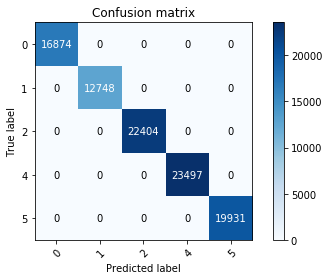

In [18]:
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
import numpy as np


exp_yml_name = 'experiments/exp_01.yml'
X_test, y_test = prepare_data(exp_yml_name, training=False)
model_path = 'output/exp1/random_forest_none_none.pkl'
clf = joblib.load(model_path)
test_preds = clf.predict(X_test)
accuracy = round(accuracy_score(y_test, test_preds) * 100, 1)
bal_accuracy = round(balanced_accuracy_score(y_test, test_preds) * 100, 1)
f1 = round(f1_score(y_test, test_preds, average='weighted', labels=np.unique(test_preds)), 2)
res_str = ('Test accuracy = ' + str(accuracy) + '%, balanced accuracy = ' + str(bal_accuracy) 
           +'%, F1 = ' + str(f1))
print(res_str)

disp = plot_confusion_matrix(y_test, test_preds, classes=np.sort(np.unique(test_preds)))

Our attack detection model provided 100% accuracy even on the test set.

#### 5.7.2 Attack Prediction Model

Though the model accuracy of the experiement1 is 100% utility of that model is limited since the model depends on frame description of current time. Hence, we will be selecting model build during Experiement2 as our final model.

C:\Users\Vinay\Anaconda3_py37\envs\savorypy\lib\site-packages\sklearn\metrics\classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\Vinay\Anaconda3_py37\envs\savorypy\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test accuracy = 56.9%, balanced accuracy = 54.7%, F1 = 0.54


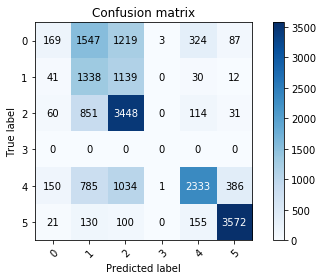

In [19]:
exp_yml_name = 'experiments/exp_02.yml'
X_test, y_test = prepare_data(exp_yml_name, training=False)
model_path = 'output/exp2/random_forest_standard_scalar_none.pkl'
clf = joblib.load(model_path)
test_preds = clf.predict(X_test)
accuracy = round(accuracy_score(y_test, test_preds) * 100, 1)
bal_accuracy = round(balanced_accuracy_score(y_test, test_preds) * 100, 1)
f1 = round(f1_score(y_test, test_preds, average='weighted', labels=np.unique(test_preds)), 2)
res_str = ('Test accuracy = ' + str(accuracy) + '%, balanced accuracy = ' + str(bal_accuracy) 
           +'%, F1 = ' + str(f1))
print(res_str)

disp = plot_confusion_matrix(y_test, test_preds, classes=np.sort(np.unique(test_preds)))

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test[test_preds != 3], test_preds[test_preds != 3], np.sort(np.unique(test_preds))))

              precision    recall  f1-score   support

           0       0.38      0.05      0.09      3346
           1       0.29      0.52      0.37      2560
           2       0.50      0.77      0.60      4504
           3       0.00      0.00      0.00         0
           4       0.79      0.50      0.61      4688
           5       0.87      0.90      0.89      3978

   micro avg       0.57      0.57      0.57     19076
   macro avg       0.47      0.46      0.43     19076
weighted avg       0.60      0.57      0.54     19076



C:\Users\Vinay\Anaconda3_py37\envs\savorypy\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Vinay\Anaconda3_py37\envs\savorypy\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Our model provided test accuracy of 56% which is consistent with validation accuracy. Further analysis of the accuracy score reveal that, we have a promising F1 score for actual attacks.

- 2 : DDOS (Distributed denial of service) attack => F1 Score = 0.6
- 4 : Scan Attack                                 => F1 Score = 0.61
- 5 : Man In the Middle Attack                    => F1 Score = 0.89

## 6.0 Conclusion

A system that can detect or predict cyber attacks is instrumental in preventing any harm caused by such attacks. In this project we have showcased a Machine Learning model which can identify three types of attacks namely 
- Distributed denial of service (DDOS) attack
- Port Scan Attack
- Man In the Middle Attack

We developed a model search mechanism which exhaustively searched for optimal model over several possible classification approaches. While our model detected the attacks with 100% accuracy, our best attack predictor model based on Random Forest could detect *Man In the Middle Attack* about 2 seconds in advance with promising F1 score of 0.89.

We have also explored the utility of **PyEEG** library for this problem. However, at this point we could not improve the model accuracy using these APIs. In our future work we will explore better ways of using this library.

# Appendix

## A. Experiment 1 Model Scores

### A.1 Logistic Regression Results 

In [21]:
exp1_scores[exp1_scores.classifier == 'logistic'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
21,logistic,min_max,none,69.70300141427897,80.78367427611424,0.9310333181733133
22,logistic,min_max,pca,69.68728720339426,80.76885067694435,0.930797631758022
24,logistic,none,none,69.47776439159814,80.57120268801265,0.9258897787685004
19,logistic,none,pca,69.9780001047614,81.04308726158712,0.93335124537467
23,logistic,standard_scalar,none,69.63752553559269,80.72190927957307,0.9282745131251647
20,logistic,standard_scalar,pca,69.97538106961395,81.04061666172547,0.9333123556781132


### A.2 Naive Bayes Results 

In [22]:
exp1_scores[exp1_scores.classifier == 'naive_bayes'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
16,naive_bayes,min_max,none,72.2172751558326,83.15545014329479,0.9645616438222225
17,naive_bayes,min_max,pca,72.20679901524278,83.14556774384822,0.9644168129516069
6,naive_bayes,none,none,99.83500078571055,99.84435220871629,0.9983497698323407
7,naive_bayes,none,pca,99.83500078571055,99.84435220871629,0.9983497698323407
8,naive_bayes,standard_scalar,none,99.83500078571055,99.84435220871629,0.9983497698323407
9,naive_bayes,standard_scalar,pca,99.83500078571055,99.84435220871629,0.9983497698323407


### A.3 KNN Results

In [23]:
exp1_scores[exp1_scores.classifier == 'knn'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
4,knn,min_max,none,99.99738096485254,99.99752940013836,0.999973809370695
0,knn,none,none,100.0,100.0,1.0
5,knn,standard_scalar,none,99.99738096485254,99.99752940013836,0.999973809370695


### A.4 Random Forest Results

In [24]:
exp1_scores[exp1_scores.classifier == 'random_forest'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
2,random_forest,min_max,none,100.0,100.0,1.0
1,random_forest,none,none,100.0,100.0,1.0
3,random_forest,standard_scalar,none,100.0,100.0,1.0


### A.5 XGBoost Results

In [25]:
exp1_scores[exp1_scores.classifier == 'xgboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
11,xgboost,min_max,none,99.83500078571055,99.84435220871629,0.9983488783710699
10,xgboost,none,none,99.83500078571055,99.84435220871629,0.9983488783710699
12,xgboost,standard_scalar,none,99.83500078571055,99.84435220871629,0.9983488783710699


### A.6 Adaboost Results

In [26]:
exp1_scores[exp1_scores.classifier == 'adaboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
26,adaboost,min_max,none,45.306689015766594,50.0,0.7329299584042729
25,adaboost,none,none,45.306689015766594,50.0,0.7329299584042729
27,adaboost,standard_scalar,none,45.306689015766594,50.0,0.7329299584042729


### A.7 Gradboost Results

In [27]:
exp1_scores[exp1_scores.classifier == 'gradboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
14,gradboost,min_max,none,99.83500078571055,99.84435220871629,0.9983488783710699
13,gradboost,none,none,99.83500078571055,99.84435220871629,0.9983488783710699
15,gradboost,standard_scalar,none,99.83500078571055,99.84435220871629,0.9983488783710699


### A.8 SVC Results

In [28]:
exp1_scores[exp1_scores.classifier == 'svc'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
18,svc,standard_scalar,none,72.11251374993452,83.05662614882894,0.9631065123171474


## B. Experiment 2  Model Scores

### B.1 Logistic Regression Results 

In [29]:
exp2_scores[exp2_scores.classifier == 'logistic'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
21,logistic,min_max,none,38.01728653745416,43.91602777985874,0.3422594839183811
41,logistic,min_max,pca,24.9083289680461,26.892711679061847,0.3124586729437176
22,logistic,none,none,38.35777894185438,43.70478097539294,0.34280740321155095
42,logistic,none,pca,23.20586694604505,26.56905292491174,0.2086467072940699
24,logistic,standard_scalar,none,37.87323205866946,43.05130972530946,0.3183734432718636
40,logistic,standard_scalar,pca,24.751178627553692,27.307344284641815,0.3042426825898383


### B.2 Naive Bayes Results 

In [30]:
exp2_scores[exp2_scores.classifier == 'naive_bayes'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
31,naive_bayes,min_max,none,35.8171817705605,41.20150620021547,0.30607697883873924
39,naive_bayes,min_max,pca,29.91094814038764,34.6067027873326,0.3051852955557362
29,naive_bayes,none,none,35.8171817705605,41.21807207532612,0.3060589008839811
38,naive_bayes,none,pca,31.08957569408067,38.08842793289793,0.3511464380252824
30,naive_bayes,standard_scalar,none,35.8040859088528,41.20674961155801,0.30590789405588037
36,naive_bayes,standard_scalar,pca,34.31115767417496,39.50729742626392,0.274664655998251


### B.3 KNN Results

In [31]:
exp2_scores[exp2_scores.classifier == 'knn'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
5,knn,min_max,none,54.33473022524882,47.77605318197958,0.5401890034688107
19,knn,min_max,pca,53.94185437401781,44.9881665393091,0.534662334796836
3,knn,none,none,53.8108957569408,48.286852593996656,0.5343482773353966
25,knn,none,pca,52.22629649030907,42.3178752412007,0.5118651969216828
4,knn,standard_scalar,none,54.282346778418024,48.07285008347134,0.539003298403619
26,knn,standard_scalar,pca,53.01204819277109,41.762097149328184,0.5159819229280758


### B.4 Random Forest Results

In [32]:
exp2_scores[exp2_scores.classifier == 'random_forest'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
2,random_forest,min_max,none,56.54793085385018,48.414227385390134,0.5260681425178284
9,random_forest,min_max,pca,53.6930330015715,47.36666004929446,0.5329703047216525
1,random_forest,none,none,56.11576741749607,48.52094636667662,0.5222481048559067
10,random_forest,none,pca,54.649030906233634,47.095727763298626,0.5213191281749029
0,random_forest,standard_scalar,none,56.54793085385018,48.6838392728484,0.5246877056022392
20,random_forest,standard_scalar,pca,52.671555788370874,44.023902262061384,0.5169702984307353


### B.5 XGBoost Results

In [33]:
exp2_scores[exp2_scores.classifier == 'xgboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
12,xgboost,min_max,none,55.85385018334207,46.77420483292896,0.5257332567188542
17,xgboost,min_max,pca,51.61079099004715,45.60555345792564,0.5033254153196358
11,xgboost,none,none,55.85385018334207,46.77420483292896,0.5257332567188542
18,xgboost,none,pca,54.04662126767942,45.401376276538215,0.5190811710309627
13,xgboost,standard_scalar,none,55.85385018334207,46.77420483292896,0.5257332567188542
32,xgboost,standard_scalar,pca,49.51545311681509,41.1785977151577,0.46320017564610405


### B.6 Adaboost Results

In [34]:
exp2_scores[exp2_scores.classifier == 'adaboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
33,adaboost,min_max,none,52.86799371398638,40.95693951970845,0.49953325367335916
16,adaboost,min_max,pca,50.013095861707704,45.63920319282908,0.4859210717707671
28,adaboost,none,none,52.86799371398638,41.315845637112766,0.5001855534972656
23,adaboost,none,pca,52.57988475641697,43.5873896932647,0.4925686558867178
35,adaboost,standard_scalar,none,52.85489785227868,40.45017763459393,0.49321015958427683
37,adaboost,standard_scalar,pca,46.76532215819801,38.482952947999486,0.4374413145990173


### B.7 Gradboost Results

In [35]:
exp2_scores[exp2_scores.classifier == 'gradboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
6,gradboost,min_max,none,56.469355683603986,47.624158528862964,0.5391106776392328
14,gradboost,min_max,pca,53.32634887375589,46.211095693781196,0.5216208961342597
8,gradboost,none,none,56.36458878994238,47.58788547520575,0.5373389013189824
15,gradboost,none,pca,53.8108957569408,45.74015609001431,0.5215772975650368
7,gradboost,standard_scalar,none,56.351492928234684,47.60406275872815,0.5375965079537143
34,gradboost,standard_scalar,pca,50.1047668936616,40.816407724283856,0.4828794593377756


### B.8 SVC Results

In [36]:
exp2_scores[exp2_scores.classifier == 'svc'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
27,svc,standard_scalar,none,38.606600314300685,41.496906906090494,0.36775256287699104


## C. Experiment 3  Model Scores

### C.1 Logistic Regression Results 

In [37]:
exp3_scores[exp3_scores.classifier == 'logistic'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
30,logistic,min_max,none,32.81762160744723,37.16617823714403,0.35669605642080393
34,logistic,min_max,pca,29.35623443031336,34.68317575157289,0.24263922581468825
28,logistic,none,none,33.814081552379704,37.74904872241738,0.37115492327774313
42,logistic,none,pca,16.74314933787859,21.92728064960182,0.1546072104104606
24,logistic,standard_scalar,none,34.20742100432673,38.10682641911556,0.2924027214613716
41,logistic,standard_scalar,pca,23.705257637341028,24.84207345342421,0.18139177912368684


### C.2 Naive Bayes Results 

In [38]:
exp3_scores[exp3_scores.classifier == 'naive_bayes'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
31,naive_bayes,min_max,none,31.92605218303396,36.27105000296779,0.27112544591117455
36,naive_bayes,min_max,pca,31.02137144355579,34.43074756097828,0.2579321745304092
32,naive_bayes,none,none,31.79493903238495,36.22273980822121,0.27008494401914257
40,naive_bayes,none,pca,28.43844237577029,33.350646432388814,0.3174860590691927
33,naive_bayes,standard_scalar,none,31.768716402255148,36.10730720142948,0.26994984262691135
38,naive_bayes,standard_scalar,pca,30.66736593680346,33.728464945945305,0.4415215791444591


### C.3 KNN Results

In [39]:
exp3_scores[exp3_scores.classifier == 'knn'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
18,knn,min_max,none,47.004064507670115,40.594714417268065,0.4606713800025722
6,knn,min_max,pca,46.12560639832175,41.99523807465204,0.4540349189326988
39,knn,none,none,35.58410908614134,33.54839706912709,0.35174603428947204
21,knn,none,pca,45.96827061754294,39.563449082395024,0.45286276383730534
17,knn,standard_scalar,none,46.702504261177396,40.78670556093806,0.45686253047563785
37,knn,standard_scalar,pca,36.01678248328307,34.20239892495328,0.33970906738212364


### C.4 Random Forest Results

In [40]:
exp3_scores[exp3_scores.classifier == 'random_forest'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
0,random_forest,min_max,none,48.0529697128622,43.25722809515686,0.4493202118288043
10,random_forest,min_max,pca,45.77160089156943,41.74497947013357,0.4523800048165273
2,random_forest,none,none,47.67274157598007,43.00029726895019,0.4664424297514885
13,random_forest,none,pca,47.20073423364363,41.63779538736151,0.4468652395736814
1,random_forest,standard_scalar,none,47.449849219876754,43.062359479183044,0.46477452689314463
25,random_forest,standard_scalar,pca,45.53559722040121,37.99917539312185,0.4424570457572574


### C.5 XGBoost Results

In [41]:
exp3_scores[exp3_scores.classifier == 'xgboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
14,xgboost,min_max,none,48.99698439753507,41.636508791756825,0.45781899203490706
8,xgboost,min_max,pca,46.09938376819195,41.8719148611884,0.4396195502974108
11,xgboost,none,none,49.08876360298938,41.73684805108467,0.4584279713725761
16,xgboost,none,pca,46.584502425593286,40.981071095760605,0.44087543091514814
12,xgboost,standard_scalar,none,49.08876360298938,41.73684805108467,0.4584279713725761
22,xgboost,standard_scalar,pca,46.21738560377606,39.157396401197914,0.4410011607319443


### C.6 Adaboost Results

In [42]:
exp3_scores[exp3_scores.classifier == 'adaboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
29,adaboost,min_max,none,44.43424675494952,37.70928902154775,0.4278417472417462
3,adaboost,min_max,pca,45.692933001180016,42.6272140709298,0.4275977618052473
26,adaboost,none,none,45.14225776845417,37.847387529837526,0.4320123546229326
19,adaboost,none,pca,47.98741313753769,40.3053322318319,0.4414927560653597
27,adaboost,standard_scalar,none,45.14225776845417,37.847387529837526,0.4320123546229326
35,adaboost,standard_scalar,pca,43.38534154975744,34.50092981494985,0.3950167600845065


### C.7 Gradboost Results

In [43]:
exp3_scores[exp3_scores.classifier == 'gradboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
7,gradboost,min_max,none,48.931427822210566,41.885224881575105,0.4526032705688334
4,gradboost,min_max,pca,46.112495083256846,42.342532911861305,0.44434970820119657
9,gradboost,none,none,49.03631834272977,41.85293652700697,0.4535638654070283
15,gradboost,none,pca,46.7418382063721,41.19960046538978,0.44319195046556104
5,gradboost,standard_scalar,none,49.403435164547005,42.2819928172707,0.458769751839472
20,gradboost,standard_scalar,pca,46.54516848039859,39.60754680708558,0.44572553735268094


### C.8 SVC Results

In [44]:
exp3_scores[exp3_scores.classifier == 'svc'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
23,svc,standard_scalar,none,35.78077881211485,38.74425104622225,0.3428335572131292


## D. Experiment 4  Model Scores

### D.1 Logistic Regression Results 

In [45]:
exp4_scores[exp4_scores.classifier == 'logistic'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
83,logistic,min_max,isomap,9.523809523809524,7.6923076923076925,0.15491559086395235
30,logistic,min_max,kpca,19.047619047619047,15.384615384615385,0.2971428571428571
99,logistic,min_max,lle,7.936507936507936,6.318681318681318,0.08465274213290165
6,logistic,min_max,none,6.349206349206349,20.421245421245423,0.08248072119039862
51,logistic,min_max,pca,14.285714285714285,11.446886446886447,0.14077041602465332
101,logistic,none,isomap,7.936507936507936,5.600539811066127,0.13596491228070176
12,logistic,none,kpca,20.634920634920633,16.666666666666664,0.34210526315789475
44,logistic,none,lle,15.873015873015872,12.820512820512823,0.11096884336320956
11,logistic,none,none,19.047619047619047,16.72608093660725,0.20177422809001758
65,logistic,none,pca,12.698412698412698,10.073260073260075,0.12350545263434501


### D.2 Naive Bayes Results 

In [46]:
exp4_scores[exp4_scores.classifier == 'naive_bayes'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
50,naive_bayes,min_max,isomap,14.285714285714285,11.538461538461538,0.10743801652892564
52,naive_bayes,min_max,kpca,14.285714285714285,11.446886446886447,0.13946505471929202
27,naive_bayes,min_max,lle,28.57142857142857,15.789473684210526,0.2671875
8,naive_bayes,min_max,none,22.22222222222222,17.513626724153042,0.1917109945205679
55,naive_bayes,min_max,pca,12.698412698412698,10.539460539460539,0.17250938430340423
33,naive_bayes,none,isomap,19.047619047619047,14.888181993445151,0.15119909988495722
13,naive_bayes,none,kpca,17.46031746031746,16.666666666666664,0.29729729729729726
91,naive_bayes,none,lle,9.523809523809524,7.287449392712551,0.06361864256601099
41,naive_bayes,none,none,17.46031746031746,13.606130711393869,0.13971796983631046
47,naive_bayes,none,pca,15.873015873015872,12.454212454212454,0.1135060814383924


### D.3 KNN Results

In [47]:
exp4_scores[exp4_scores.classifier == 'knn'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
61,knn,min_max,isomap,12.698412698412698,10.356310356310356,0.15353535353535352
40,knn,min_max,kpca,17.46031746031746,13.656080761343917,0.15403573115501096
72,knn,min_max,none,11.11111111111111,9.17722628248944,0.11751761636554263
34,knn,min_max,pca,19.047619047619047,14.372907793960424,0.2017123162903214
42,knn,none,isomap,17.46031746031746,13.404139719929194,0.19835019274009452
14,knn,none,kpca,20.634920634920633,16.666666666666664,0.34210526315789475
76,knn,none,lle,11.11111111111111,8.932733932733933,0.11033005794910557
26,knn,none,none,20.634920634920633,15.796484217536852,0.22956818569721796
48,knn,none,pca,15.873015873015872,11.827646038172356,0.14802379733255314
66,knn,standard_scalar,isomap,12.698412698412698,9.993077098340256,0.11928423543330377


### D.4 Random Forest Results

In [48]:
exp4_scores[exp4_scores.classifier == 'random_forest'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
86,random_forest,min_max,isomap,9.523809523809524,7.600732600732601,0.09228989401403194
32,random_forest,min_max,kpca,19.047619047619047,14.926739926739927,0.2530365211623762
4,random_forest,min_max,lle,19.047619047619047,21.496836496836494,0.22942145237541656
53,random_forest,min_max,none,14.285714285714285,11.313686313686315,0.16841630591630594
20,random_forest,min_max,pca,20.634920634920633,16.3003663003663,0.2537878787878788
64,random_forest,none,isomap,12.698412698412698,10.084652189915348,0.10965719621181808
15,random_forest,none,kpca,20.634920634920633,16.666666666666664,0.34210526315789475
80,random_forest,none,lle,11.11111111111111,8.539267749794066,0.13910487437057487
71,random_forest,none,none,11.11111111111111,9.34898434898435,0.13578971533516987
95,random_forest,none,pca,7.936507936507936,6.4102564102564115,0.06885593220338983


### D.5 XGBoost Results

In [49]:
exp4_scores[exp4_scores.classifier == 'xgboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
56,xgboost,min_max,isomap,12.698412698412698,10.539460539460539,0.16964472309299897
39,xgboost,min_max,kpca,17.46031746031746,13.736263736263735,0.17106081333167517
97,xgboost,min_max,none,9.523809523809524,6.386157701947176,0.11375134669252315
19,xgboost,min_max,pca,20.634920634920633,16.533466533466534,0.22544500953591864
78,xgboost,none,isomap,11.11111111111111,8.791208791208792,0.13226010101010102
16,xgboost,none,kpca,1.5873015873015872,16.666666666666664,0.03125
2,xgboost,none,lle,15.873015873015872,28.30502830502831,0.19296536796536792
96,xgboost,none,none,9.523809523809524,6.386157701947176,0.11375134669252315
63,xgboost,none,pca,12.698412698412698,10.214785214785216,0.17348484848484846
3,xgboost,standard_scalar,isomap,11.11111111111111,24.500499500499497,0.11962809917355371


### D.6 Adaboost Results

In [50]:
exp4_scores[exp4_scores.classifier == 'adaboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
68,adaboost,min_max,isomap,14.285714285714285,9.82745324850588,0.15010751656714388
24,adaboost,min_max,kpca,19.047619047619047,15.9007659007659,0.15366591080876796
37,adaboost,min_max,lle,17.46031746031746,14.11088911088911,0.2517439793832756
59,adaboost,min_max,none,12.698412698412698,10.447885447885447,0.12407629718554086
70,adaboost,min_max,pca,12.698412698412698,9.405068615594931,0.13122670276861212
69,adaboost,none,isomap,12.698412698412698,9.679793890320205,0.13406445406445405
17,adaboost,none,kpca,20.634920634920633,16.666666666666664,0.34210526315789475
62,adaboost,none,lle,12.698412698412698,10.22617733144049,0.11935553168635875
58,adaboost,none,none,12.698412698412698,10.447885447885447,0.12407629718554086
93,adaboost,none,pca,9.523809523809524,6.921149026412183,0.1181554747502866


### D.7 Gradboost Results

In [51]:
exp4_scores[exp4_scores.classifier == 'gradboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
92,gradboost,min_max,isomap,9.523809523809524,7.012724117987276,0.10261022927689593
22,gradboost,min_max,kpca,20.634920634920633,16.208791208791208,0.21519340874179582
31,gradboost,min_max,lle,15.873015873015872,15.246420246420248,0.18204602415128732
89,gradboost,min_max,none,9.523809523809524,7.348791559317876,0.11708117590470533
46,gradboost,min_max,pca,15.873015873015872,12.728937728937728,0.12067613146129107
67,gradboost,none,isomap,12.698412698412698,9.851551956815115,0.12319109461966606
18,gradboost,none,kpca,20.634920634920633,16.666666666666664,0.34210526315789475
94,gradboost,none,lle,9.523809523809524,6.791016001542317,0.11023090526196117
88,gradboost,none,none,9.523809523809524,7.348791559317876,0.11708117590470533
103,gradboost,none,pca,4.761904761904762,3.8461538461538463,0.05138339920948618


### D.8 SVC Results

In [52]:
exp4_scores[exp4_scores.classifier == 'svc'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
36,svc,standard_scalar,none,17.46031746031746,14.13367334419966,0.19515243134290755


## E. Experiment 5  Model Scores

### E.1 Logistic Regression Results 

In [53]:
exp5_scores[exp5_scores.classifier == 'logistic'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
47,logistic,min_max,isomap,16.666666666666664,13.58974358974359,0.14583333333333331
18,logistic,min_max,kpca,24.074074074074073,16.666666666666664,0.3880597014925373
19,logistic,min_max,lle,24.074074074074073,16.666666666666664,0.3880597014925373
99,logistic,min_max,none,9.25925925925926,7.179487179487181,0.09444444444444446
88,logistic,min_max,pca,9.25925925925926,8.846153846153848,0.07530364372469636
42,logistic,none,isomap,14.814814814814813,14.358974358974361,0.13498622589531678
16,logistic,none,kpca,24.074074074074073,16.666666666666664,0.3880597014925373
17,logistic,none,lle,24.074074074074073,16.666666666666664,0.3880597014925373
78,logistic,none,none,14.814814814814813,10.457875457875458,0.13689447022780357
92,logistic,none,pca,11.11111111111111,8.41991341991342,0.13637226970560304


### E.2 Naive Bayes Results 

In [54]:
exp5_scores[exp5_scores.classifier == 'naive_bayes'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
77,naive_bayes,min_max,isomap,12.962962962962962,11.025641025641027,0.14518229166666669
57,naive_bayes,min_max,kpca,14.814814814814813,12.307692307692308,0.10566420014094434
21,naive_bayes,min_max,lle,24.074074074074073,16.666666666666664,0.3880597014925373
79,naive_bayes,min_max,none,9.25925925925926,10.32967032967033,0.10236879666227493
91,naive_bayes,min_max,pca,9.25925925925926,8.46153846153846,0.1103197877391426
95,naive_bayes,none,isomap,5.555555555555555,7.94871794871795,0.06004901960784313
20,naive_bayes,none,kpca,18.51851851851852,16.666666666666664,0.3125
38,naive_bayes,none,lle,18.51851851851852,14.871794871794872,0.26973684210526316
50,naive_bayes,none,none,12.962962962962962,12.71062271062271,0.18937389770723106
64,naive_bayes,none,pca,14.814814814814813,12.082917082917083,0.17865418894830662


### E.3 KNN Results

In [55]:
exp5_scores[exp5_scores.classifier == 'knn'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
11,knn,min_max,isomap,22.22222222222222,18.223443223443223,0.2269426289034132
6,knn,min_max,kpca,22.22222222222222,20.183150183150186,0.26492368061055516
104,knn,min_max,lle,7.4074074074074066,4.945054945054945,0.08751714677640604
73,knn,min_max,none,14.814814814814813,11.428571428571429,0.1471121471121471
46,knn,min_max,pca,16.666666666666664,13.84115884115884,0.17149178197038203
9,knn,none,isomap,25.925925925925924,19.02930402930403,0.26780921708457944
22,knn,none,kpca,24.074074074074073,16.666666666666664,0.3880597014925373
48,knn,none,lle,14.814814814814813,13.126873126873129,0.15748243302591125
4,knn,none,none,27.77777777777778,22.655677655677657,0.25476646597336255
37,knn,none,pca,18.51851851851852,14.921744921744923,0.16730831708901886


### E.4 Random Forest Results

In [56]:
exp5_scores[exp5_scores.classifier == 'random_forest'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
75,random_forest,min_max,isomap,12.962962962962962,11.41025641025641,0.13931804629479047
100,random_forest,min_max,kpca,9.25925925925926,6.7032967032967035,0.12130165027645295
31,random_forest,min_max,lle,18.51851851851852,16.025641025641026,0.19916943521594682
60,random_forest,min_max,none,12.962962962962962,12.17948717948718,0.15886439142253098
83,random_forest,min_max,pca,11.11111111111111,10.12820512820513,0.13197837274444665
0,random_forest,none,isomap,22.22222222222222,33.699633699633694,0.22882877430807713
23,random_forest,none,kpca,24.074074074074073,16.666666666666664,0.3880597014925373
30,random_forest,none,lle,18.51851851851852,16.10722610722611,0.1781958144942363
59,random_forest,none,none,12.962962962962962,12.17948717948718,0.14383918550585215
15,random_forest,none,pca,22.22222222222222,17.577422577422578,0.1730964750572594


### E.5 XGBoost Results

In [57]:
exp5_scores[exp5_scores.classifier == 'xgboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
14,xgboost,min_max,isomap,18.51851851851852,17.692307692307697,0.2130837912087912
82,xgboost,min_max,kpca,11.11111111111111,10.178155178155178,0.1261797872908984
7,xgboost,min_max,lle,24.074074074074073,19.976689976689975,0.1869178440607012
62,xgboost,min_max,none,14.814814814814813,12.087912087912088,0.15701459034792367
94,xgboost,min_max,pca,11.11111111111111,8.126873126873129,0.15182764463810214
3,xgboost,none,isomap,27.77777777777778,23.16350316350316,0.30147396327951886
24,xgboost,none,kpca,18.51851851851852,16.666666666666664,0.3125
41,xgboost,none,lle,16.666666666666664,14.733599733599734,0.17540547083030744
61,xgboost,none,none,14.814814814814813,12.087912087912088,0.15701459034792367
12,xgboost,none,pca,22.22222222222222,17.87046287046287,0.21134014859505057


### E.6 Adaboost Results

In [58]:
exp5_scores[exp5_scores.classifier == 'adaboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
87,adaboost,min_max,isomap,12.962962962962962,9.56043956043956,0.16594045025417575
69,adaboost,min_max,kpca,12.962962962962962,11.551781551781554,0.14265948222469962
86,adaboost,min_max,lle,12.962962962962962,9.652014652014653,0.13010778561336617
1,adaboost,min_max,none,14.814814814814813,26.520146520146522,0.15775630703166937
56,adaboost,min_max,pca,12.962962962962962,12.472527472527473,0.11109864072827035
58,adaboost,none,isomap,16.666666666666664,12.206127206127208,0.1693562610229277
25,adaboost,none,kpca,18.51851851851852,16.666666666666664,0.3125
53,adaboost,none,lle,14.814814814814813,12.6007326007326,0.14050863447793271
33,adaboost,none,none,16.666666666666664,15.8974358974359,0.13324420677361853
43,adaboost,none,pca,16.666666666666664,14.207459207459209,0.14660938190349956


### E.7 Gradboost Results

In [59]:
exp5_scores[exp5_scores.classifier == 'gradboost'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
45,gradboost,min_max,isomap,20.37037037037037,14.102564102564102,0.18571428571428572
102,gradboost,min_max,kpca,5.555555555555555,5.8058608058608066,0.05615196516967854
93,gradboost,min_max,lle,11.11111111111111,8.21844821844822,0.12859477124183008
71,gradboost,min_max,none,16.666666666666664,11.538461538461538,0.19897959183673472
68,gradboost,min_max,pca,12.962962962962962,11.794871794871796,0.13019079685746357
5,gradboost,none,isomap,25.925925925925924,20.311355311355314,0.29000536768652707
26,gradboost,none,kpca,24.074074074074073,16.666666666666664,0.3880597014925373
54,gradboost,none,lle,12.962962962962962,12.564102564102567,0.11980920314253647
70,gradboost,none,none,16.666666666666664,11.538461538461538,0.19897959183673472
44,gradboost,none,pca,16.666666666666664,14.115884115884118,0.17175475399026166


### E.8 SVC Results

In [60]:
exp5_scores[exp5_scores.classifier == 'svc'].sort_values(by=['preprocess', 'transform'])

,classifier,preprocess,transform,accuracy,balanced_accuracy,f1_score
55,svc,standard_scalar,none,12.962962962962962,12.564102564102567,0.11686369540775672
